In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from utils import wavelength_to_rgb

In [19]:
# measurements
dist = {
    'b': np.array([7.6,7.6,7.6,7.7]),
    'g': np.array([8.4,8.4,8.8,8.5]),
    't': np.array([9.7,9.6,9.6,9.6]),
    'r': np.array([11,10.9,11,11])
}
widths = {
    'b': np.array([0.2,0.2,0.2,0.1]),
    't': np.array([0.3,0.4,0.3,0.4]),
    'g': np.array([0.3,0.4,0.2,0.4]),
    'r': np.array([0.2,0.2,0.2,0.2])
}
ddist = 0.1
L = 33.9
dL = 0.5
N0 = 5030
dN0 = 69
# labels = {
#     'b': '',
#     'g': '',
#     't': '',
#     'r': '',
# }
# real = {
#     'a': 656.279,
#     'b': 486.135,
#     'c': 434.047
# }
keys = list(dist.keys())

In [22]:
# fit N to derive wavelengths
lamb = dict()
dlamb = dict()
dw = dict()
w = dict()

lamodel = lambda d, N: np.mean(np.sin(np.arctan(d/L))/N, axis=1) * 1e7
dlamodel = lambda d, N: (np.std(np.sin(np.arctan(d/L))/N, axis=1) * 1e7)
distlist = np.array([dist[key] for key in keys])
# reallist = np.array([real[key] for key in keys])
# [N], [[dN]] = sp.optimize.curve_fit(
#     lamodel, distlist, reallist,
#     p0=[N0]
# )
N = 5040.666797550959
dN = 257.30220282372017

# lares = lamodel(distlist, N) - reallist
# lachi2 = np.sum((lares/dlamodel(distlist, N))**2)
# larchi2 = lachi2 / (reallist.size - 1)

for key in keys:
    lamb[key] = lamodel(np.array([dist[key]]), N)[0]
    dlamb[key] = dlamodel(np.array([dist[key]]), N)[0]
    w[key] = lamodel(np.array([dist[key] + widths[key]/2]), N)[0] - lamodel(np.array([dist[key] - widths[key]/2]), N)[0]
    dw[key] = np.mean(0.05/widths[key])*w[key]

{'N': N, 'dN': dN }

{'N': 5040.666797550959, 'dN': 257.30220282372017}

In [14]:
h = 1240 # eV nm

(1.0, 0.0)

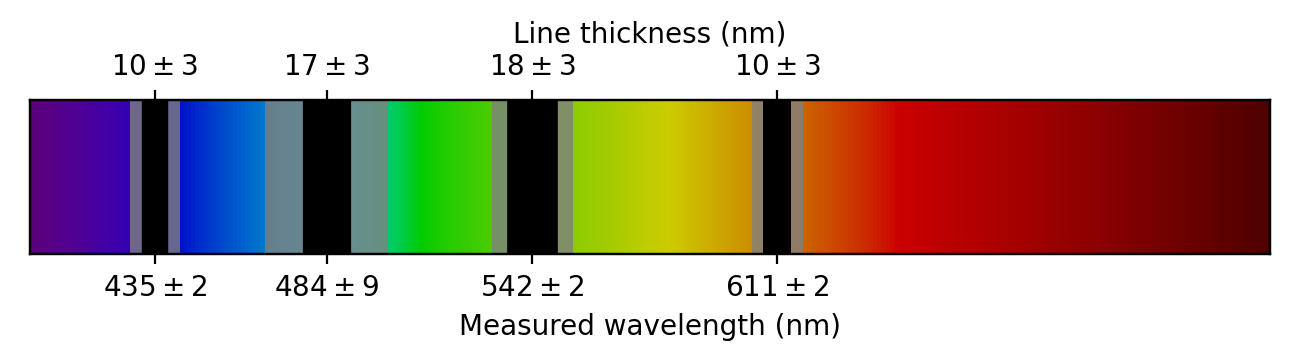

In [28]:
fig, ax = plt.subplots(figsize=(8, 1), dpi=200)
lmin = 400
lmax = 750
space = np.linspace(lmax, lmin, 300)
plt.xlabel('Measured wavelength (nm)')
ax.set_xlim(lmin, lmax)

y = 0
for key in keys:
    plt.axvspan(lamb[key] - w[key]/2 - dlamb[key], lamb[key] + w[key]/2 + dlamb[key], facecolor='gray', alpha=0.8)
    plt.axvline(lamb[key], color='black', lw=w[key])
    # plt.axvline(real[key], color='white', lw=1, ymin=0.2)
    # plt.text(real[key]+3, 0.8, labels[key], color='white', rotation='vertical')

ax.set_xticks([lamb[key] for key in keys], labels=[f'${lamb[key]:.0f} \pm {dlamb[key]:.0f}$' for key in keys])
ax.set_yticks([])
ax.set_ylim(0, 1)
ax.imshow([wavelength_to_rgb(space)*0.8], extent=[np.max(space), np.min(space), 0, 1], aspect='auto')

fax = ax.twiny()
fax.set_xlim(lmin, lmax)
fax.set_xticks([lamb[key] for key in keys], labels = [f'${w[key]:.0f} \pm {dw[key]:.0f}$' for key in keys])
fax.set_xlabel('Line thickness (nm)')
fax.set_ylim(1,0)

In [406]:
lam = np.array(list(lamb.values()))
dlam = np.array(list(dlamb.values()))
ll = 1/lam * 1e3
dll = (dlam/lam/lam) * 1e3
ni = np.array([3, 4, 5])
nn = 1/4 - 1/ni/ni

In [370]:
model = lambda nn, Ry: Ry*nn/1.24
[Ry], [[dRy]] = sp.optimize.curve_fit(
    model, nn, ll, 
    p0=[13.6], sigma=dll
)
dRy = np.sqrt(dRy)
Ry, dRy

(13.594706846403339, 0.04038706349460046)

In [420]:
res = ll - model(nn, Ry)
err = (model(nn, Ry+dRy) - model(nn, Ry-dRy))
normres = res / err
chi2 = np.sum(normres*normres)
rchi2 = chi2/2
rchi2

0.9516480403860236

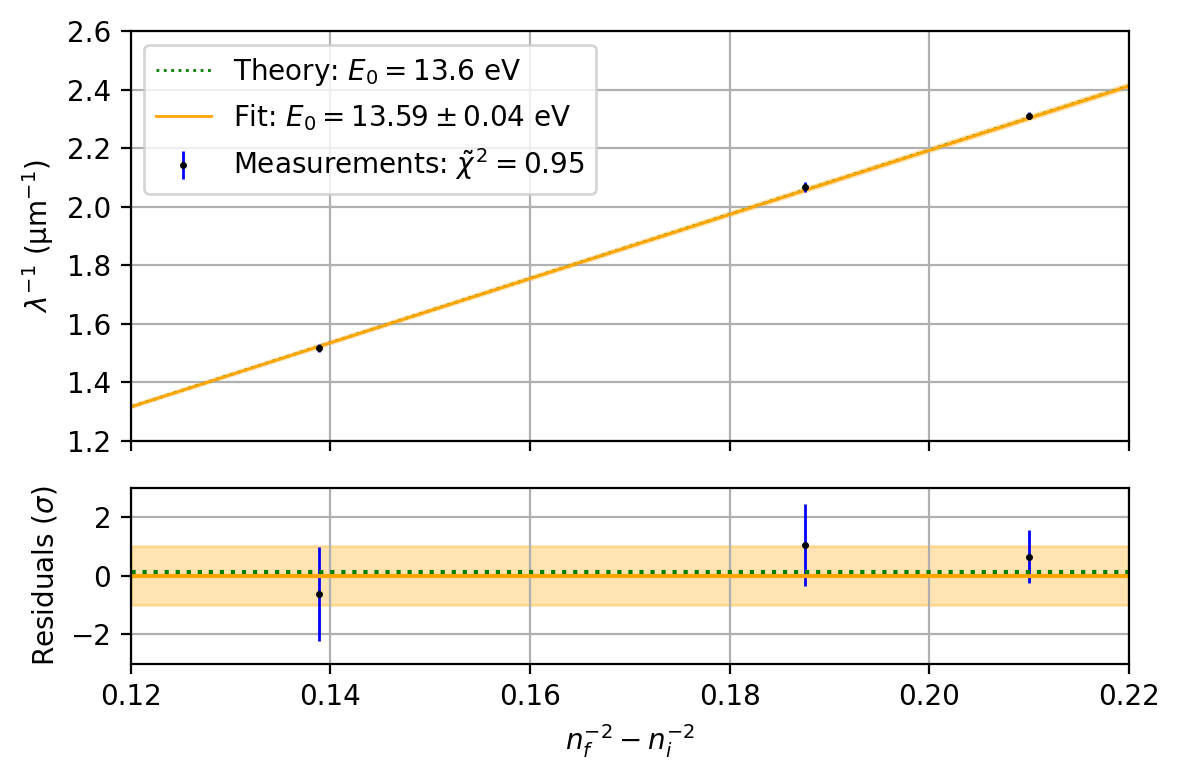

In [421]:
fig, (ax, ax_res) = plt.subplots(
    2, 1, sharex=True, 
    figsize=(6, 4), dpi=200, 
    gridspec_kw={'height_ratios': [7, 3]}
)

plt.sca(ax)

space = np.linspace(0.1, 0.3)
plt.plot(space, model(space, 13.6), color='green', lw=1,
            label=f'Theory: $E_0 = 13.6$ eV', ls=':'
)

plt.plot(space, model(space, Ry), color='orange', lw=1,
            label=f'Fit: $E_0 = {Ry:.2f} \pm {dRy:.2f}$ eV'
)
plt.fill_between(space, model(space, Ry-dRy), model(space, Ry+dRy), color='orange', alpha=0.3)
plt.errorbar(
    nn, ll, yerr = dll,
    ecolor="blue", color='black', 
    linewidth = 0, elinewidth = 1, markersize = 3, marker='.',
    label=f'Measurements: $\\tilde\chi^2 = {rchi2:.2f}$'
)

plt.ylabel('$\lambda^{-1}$ (μm$^{-1}$)')
plt.xlim(0.12, 0.22)
plt.ylim(1.2, 2.6)
plt.legend(loc='upper left')
plt.grid()

plt.sca(ax_res)
plt.errorbar(
    nn, res/err, yerr = dll/err,
    ecolor="blue", color='black', 
    linewidth = 0, elinewidth = 1, markersize = 3, marker='.'
)
plt.ylim(-3, 3)
plt.axhspan(-1, 1, color='orange', alpha=0.3)
plt.axhline(0, color='orange')
errspace = (model(space, Ry+dRy) - model(space, Ry-dRy))/2
plt.plot((model(space, 13.6)-model(space, Ry))/errspace, color='green', ls=':')
plt.xlabel('$n_f^{-2} - n_i^{-2}$')
plt.ylabel('Residuals ($\sigma$)')
plt.grid()

plt.tight_layout()